# 前言
我们使用利用概率模型建立一个回归模型来预测波士顿房价。

参考：https://github.com/tensorflow/probability/tree/v0.17.0/tensorflow_probability/examples/models

用到的库

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from keras.utils.vis_utils import plot_model
import os
from keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context # 解决 [SSL: CERTIFICATE_VERIFY_FAILED] 问题
tfd = tfp.distributions

# 训练和测试数据获取
波斯顿房价数据集

(404, 13) (404,)


<AxesSubplot:xlabel='cost', ylabel='Count'>

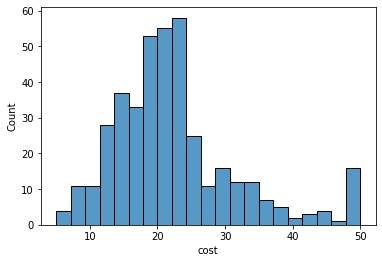

In [2]:
from keras.datasets import boston_housing
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
print(x_train.shape,y_train.shape)
data = {'set':'train','cost':y_train.flatten()} # 转成dataframe格式 便于绘图
df1 = pd.DataFrame(data)
sns.histplot(data=df1,x='cost')

# 模型
这里是4层全连接的结构，权重为高斯正态，输出也为高斯分布。

In [33]:
def Bayesian_DNN():
  #=== 2 维输出， 一个用于拟合分布的均值， 另一个用于拟合方差 ---- 
  # 归一化KL散度，免得其过大
  KL = (lambda q, p, _: tfd.kl_divergence(q, p)/len(x_train))#KL散度/样本数目
  # 输出服从正态分布 softplus系数 一开始最好用1e-5,1e-4 如果发现std不够再加大
  normal_sp = lambda t: tfd.Normal(loc=t[...,0],scale=1e-3+tf.math.softplus(1e-3*t[...,1])) 
  Inpt = tf.keras.layers.Input(shape=(13,))
  x = tfp.layers.DenseFlipout(32,activation='relu',kernel_divergence_fn=KL,bias_divergence_fn=KL)(Inpt)
  x = tfp.layers.DenseFlipout(128,activation='relu',kernel_divergence_fn=KL,bias_divergence_fn=KL)(x)
  x = tfp.layers.DenseFlipout(128,activation='relu',kernel_divergence_fn=KL,bias_divergence_fn=KL)(x)
  x = tfp.layers.DenseFlipout(32,activation='relu',kernel_divergence_fn=KL,bias_divergence_fn=KL)(x)
  x = tfp.layers.DenseFlipout(2,activation=None,kernel_divergence_fn=KL,bias_divergence_fn=KL)(x)
  dist = tfp.layers.DistributionLambda(normal_sp)(x)
  model = tf.keras.Model(inputs=Inpt, outputs=dist,name='BNN_REG')
  return model

# loss , 优化器, 训练
使用negloglik作为loss，在Flipout层中KL散度会自动加上

In [34]:
model = Bayesian_DNN() #实例化
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # Adam优化器 学习率0.001
negloglik = lambda y, rv_y: -rv_y.log_prob(y)
# The Keras API will then automatically add the
# Kullback-Leibler divergence (contained on the individual layers of
# the model), to the negloglik, effectively
# calcuating the (negated) Evidence Lower Bound Loss (ELBO)
model.compile(optimizer,loss=negloglik,metrics='mae') 
plot_model(model,to_file=os.path.join('./fig',model.name+'_dataflow.pdf'),show_shapes=True,show_layer_names=False) # 绘制模型结构

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


# 训练

In [37]:
epoch, batch_size = 1000, 128
if os.path.exists(model.name+'.h5'):# 读取存在的模型继续训练
  model.load_weights(model.name+'.h5')
checkpoint = ModelCheckpoint(model.name+'.h5', monitor='mae',save_weights_only=True,verbose=1,save_best_only=True)# 仅保存最好的模型
history = model.fit(x_train,y_train, epochs=epoch,batch_size=batch_size, validation_data=(x_test,y_test),callbacks=[checkpoint],shuffle=False) # 训练

Epoch 1/1000
1/4 [======>.......................] - ETA: 0s - loss: 34.6426 - mae: 3.0276
Epoch 1: mae improved from inf to 3.05182, saving model to BNN_REG.h5
4/4 [==============================] - 0s 135ms/step - loss: 34.9421 - mae: 3.0518 - val_loss: 36.4180 - val_mae: 4.2495
Epoch 2/1000
1/4 [======>.......................] - ETA: 0s - loss: 34.5704 - mae: 3.0034
Epoch 2: mae improved from 3.05182 to 3.03884, saving model to BNN_REG.h5
4/4 [==============================] - 0s 149ms/step - loss: 34.6973 - mae: 3.0388 - val_loss: 36.5924 - val_mae: 4.1583
Epoch 3/1000
1/4 [======>.......................] - ETA: 0s - loss: 34.2660 - mae: 3.2546
Epoch 3: mae did not improve from 3.03884
4/4 [==============================] - 0s 70ms/step - loss: 34.4531 - mae: 3.0869 - val_loss: 36.2134 - val_mae: 4.2480
Epoch 4/1000
1/4 [======>.......................] - ETA: 0s - loss: 34.2698 - mae: 3.1270
Epoch 4: mae did not improve from 3.03884
4/4 [==============================] - 0s 76ms/ste

# 作为比较的DNN模型

In [6]:
def DNN():
  Inpt = tf.keras.layers.Input(shape=[13, 1])
  x = tf.keras.layers.Dense(32,activation='relu')(Inpt)
  x = tf.keras.layers.Dense(128,activation='relu')(x)
  x = tf.keras.layers.Dense(128,activation='relu')(x)
  x = tf.keras.layers.Dense(32,activation='relu')(x)
  x = tf.keras.layers.Dense(1,activation=None)(x)
  model = tf.keras.Model(inputs=Inpt, outputs=x,name='DNN_REG')
  return model
model2 = DNN() #实例化
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # Adam优化器 学习率0.001
model2.compile(optimizer,loss='mae',metrics='mae') 
model2.fit(x_train,y_train,epochs=epoch,batch_size=batch_size,validation_data=(x_test,y_test),shuffle=False) # 训练

Epoch 1/1000
4/4 [==============================] - 1s 71ms/step - loss: 21.3371 - mae: 21.3371 - val_loss: 20.5594 - val_mae: 20.5594
Epoch 2/1000
4/4 [==============================] - 0s 11ms/step - loss: 19.8482 - mae: 19.8482 - val_loss: 20.5307 - val_mae: 20.5307
Epoch 3/1000
4/4 [==============================] - 0s 13ms/step - loss: 19.7493 - mae: 19.7493 - val_loss: 20.5337 - val_mae: 20.5337
Epoch 4/1000
4/4 [==============================] - 0s 12ms/step - loss: 19.6742 - mae: 19.6742 - val_loss: 20.2124 - val_mae: 20.2124
Epoch 5/1000
4/4 [==============================] - 0s 12ms/step - loss: 19.5618 - mae: 19.5618 - val_loss: 20.1473 - val_mae: 20.1473
Epoch 6/1000
4/4 [==============================] - 0s 12ms/step - loss: 19.4997 - mae: 19.4997 - val_loss: 19.9872 - val_mae: 19.9872
Epoch 7/1000
4/4 [==============================] - 0s 13ms/step - loss: 19.3790 - mae: 19.3790 - val_loss: 19.9274 - val_mae: 19.9274
Epoch 8/1000
4/4 [==============================] - 0s 

### 通过比较发现，同样的网络结构，概率模型有着更高的准确率。当然这里有点cheating，因为概率模型的参数数量是普通模型的两倍---例如参数服从高斯分布 $\omega \sim N (\mu,\sigma)$

# 预测

选取测试集，绘制其one-to-one图

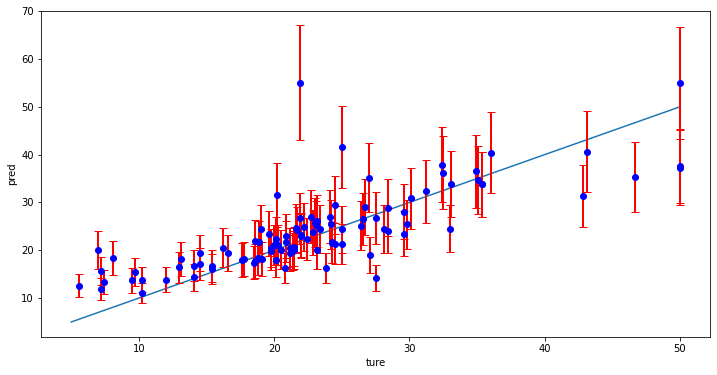

In [46]:
pred_100 = [model(x_test) for _ in range(100)]
avg_mean,avgs_std = np.zeros_like(x_test[..., 0]),np.zeros_like(x_test[..., 0])
for i, yhat in enumerate(pred_100):
  mean = np.squeeze(yhat.mean())
  std = np.squeeze(yhat.stddev())
  avg_mean += mean
  avgs_std += std
avg_mean = avg_mean / len(pred_100) #预测均值
avgs_std = avgs_std / len(pred_100) #预测std的均值

#pred = {'ture':y_test,'pred':avg_mean} # 转成dataframe格式 便于绘图
#pred = pd.DataFrame(pred)
#sns.relplot(data=pred,y='ture', x='pred')
plt.figure(figsize=(12, 6))
x = np.linspace(5,50,100)
plt.plot(x,x) # y=x
plt.xlabel('ture')
plt.ylabel('pred')
plt.errorbar(y_test, avg_mean, avgs_std,fmt='o',ecolor='r',color='b',elinewidth=2,capsize=4)
plt.show()

